# Linear regression
### Let's start off with a simple linear regression. What's linear regression? "Linear" can be think of as a straight line and "regression" is a statistical method that determines the relationship between a dependent variable (denote as *y*) and other independent variables (denote as *x1, x2 ... xn*)

### Now, what are the assumptions of linear regression?
#### 1. Linearity - As the name suggests, there is a linear relationship between x and y
#### 2. Multivariate normality - Meaning that all the variables are normally distributed. If it isn't, a non-linear transformation may fix the issue
#### 3. No or little multicollinearity -  Multicollinearity means when two or more of the predictor variables are highly correlated to each other
#### 4. No auto-correlation - Autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data. Which means, if *y(x+1)* is not independent from *y(x)*, then there is autocorrelation
#### 5. Homoscedasticity - Means that the residual/ error term does not change much and remains constant.

-- The best way to learn how linear regression works, is to just start using a dataset and try it out. The dataset chosen is weather data from Szeged that can be accessed via: https://www.kaggle.com/budincsevity/szeged-weather

In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import datetime
from pylab import rcParams
from sklearn import metrics
from statsmodels.graphics.gofplots import qqplot

import os
for dirname, _, filenames in os.walk('./lr_data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./lr_data/weatherHistory.csv


- First, let's try and understand the data and do some EDA. Load the data into df and check the first 5 values

In [16]:
df = pd.read_csv("./lr_data/weatherHistory.csv")
df.head(5)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


- Alright, so it seems like there are a couple of predictor variables that can be used to predict the temperature. We also have categorical variable like "Precip Type" that would need some pre-processing. Now let's get some intuitive information about the data

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


- Few observations that can be observed. There are categorical variables labeled as object, and numerical variables that are labeled as float64. Also, there are some missing entries in Precip Type

In [18]:
df.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [19]:
# Categorical variables:
categorical = df.select_dtypes(include = ["object"]).keys()
print("The categorical variables are: %s" %categorical)

The categorical variables are: Index(['Formatted Date', 'Summary', 'Precip Type', 'Daily Summary'], dtype='object')


In [20]:
# Numerical variables:
numerical = df.select_dtypes(include = ["int64","float64"]).keys()
print(numerical)

Index(['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Loud Cover', 'Pressure (millibars)'],
      dtype='object')


In [21]:
# We need to process the date as the current format is YY-MM-DD HH:MM
df['Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['hour'] = df['Date'].dt.hour

In [22]:
df.head(5)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,Date,year,month,day,hour
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00,2006,3,31,22
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00,2006,3,31,23
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00,2006,4,1,0
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00,2006,4,1,1
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00,2006,4,1,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CB18799F98>,
      dtype=object)

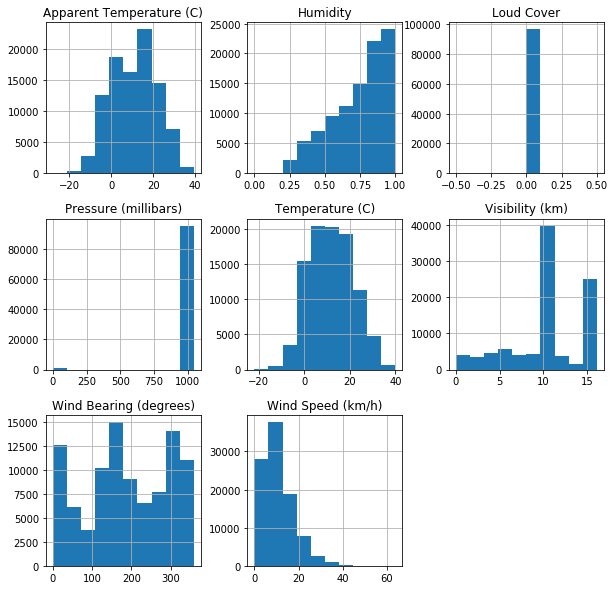

In [23]:
rcParams['figure.figsize'] = 10, 10
df[numerical].hist()

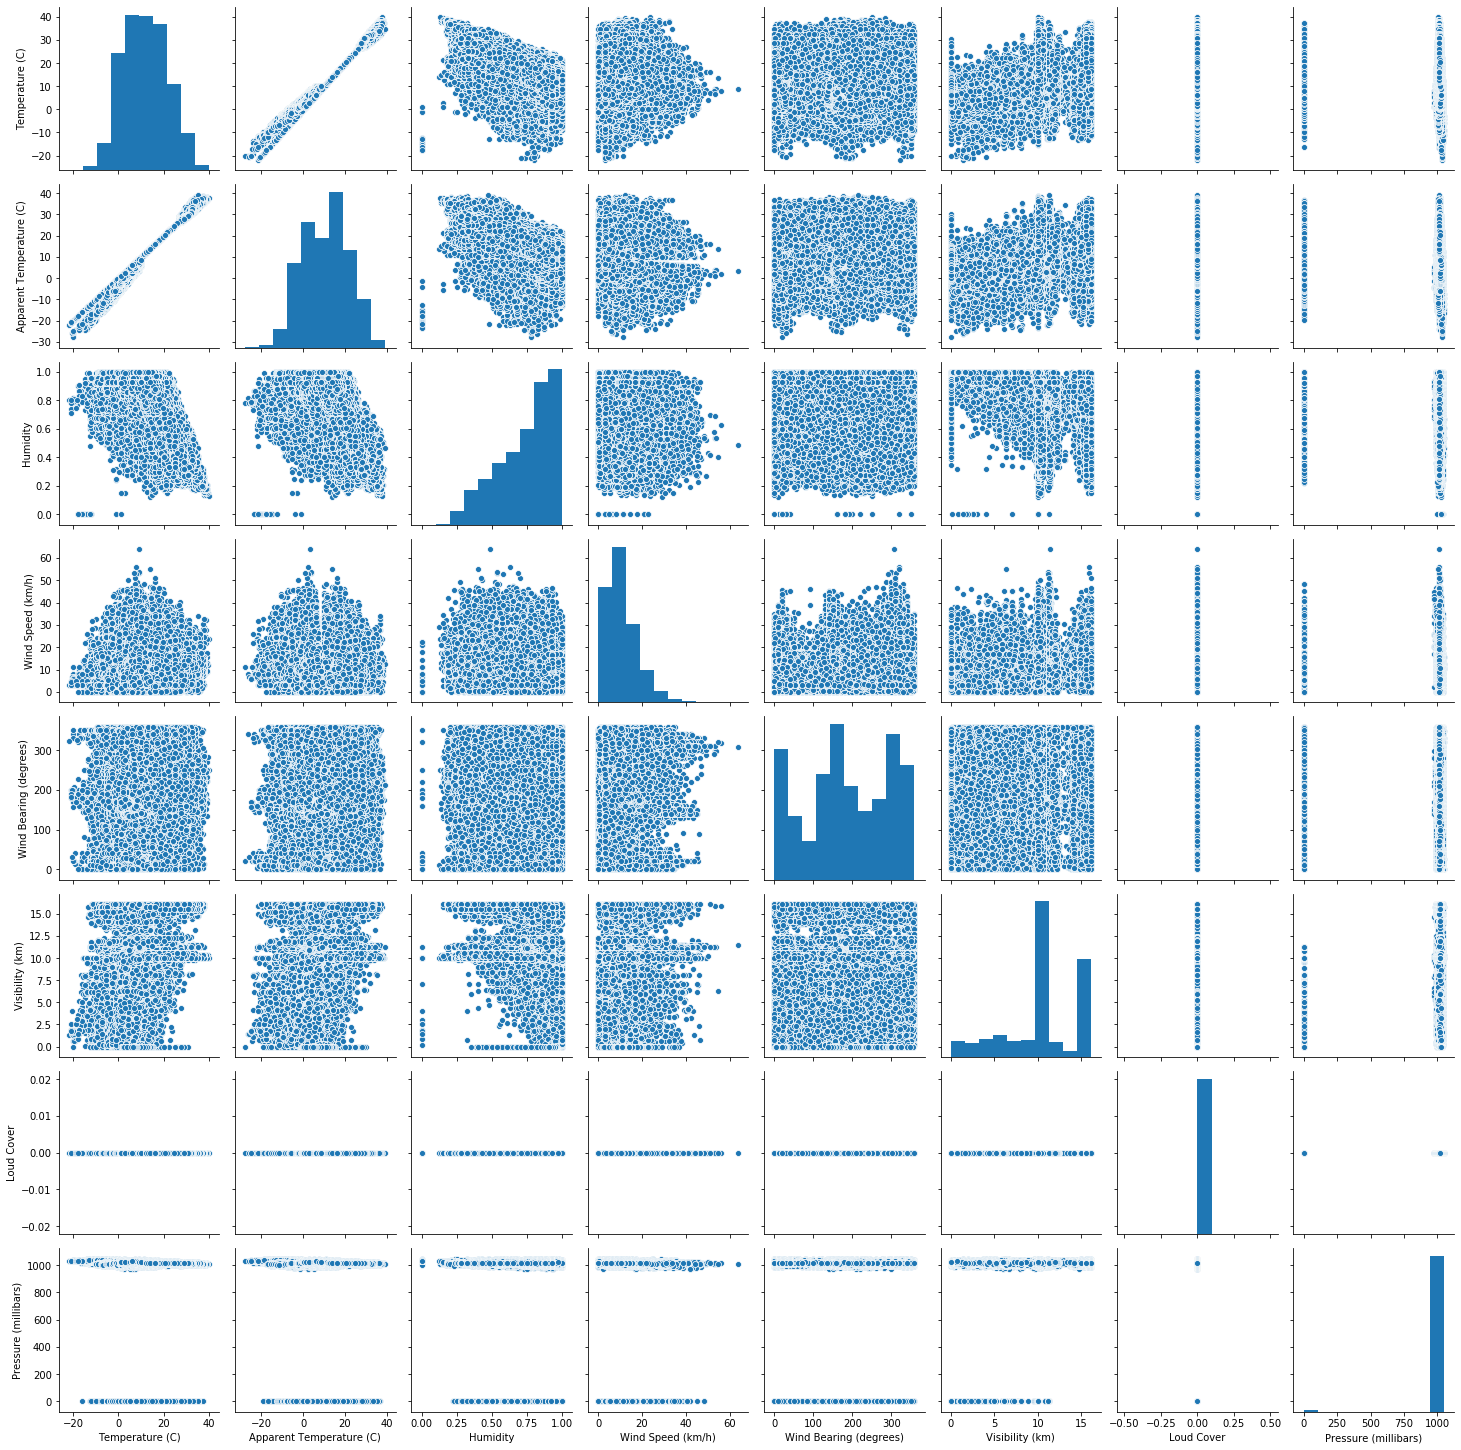

In [24]:
sns_plot = sns.pairplot(df[numerical])

In [25]:
# Loud Cover and Pressure do not have good values, so there's little predictive value to them
df=df.drop(['Loud Cover','Pressure (millibars)'],axis=1)

In [26]:
df['Summary'].value_counts()

Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Windy and Mostly Cloudy                   35
Breezy and Foggy                          35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Humid and 

In [27]:
#new categorical variable:
def cloud_categorizer(row):
   row = str(row).lower()
   category = ""
   if "foggy" in row:
       category = "Foggy"
   elif "overcast" in row:
       category = "Overcast"
   elif "mostly cloudy" in row:
       category = "Mostly cloudy"
   elif "partly cloudy" in row:
       category = "Partly cloudy"
   elif "clear" in row:
       category = "Clear"
   else:
       category = "Other Cloud condition"
   return category 

df["cloud (summary)"] = df.apply (lambda row:cloud_categorizer(row["Summary"]) , axis = 1)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

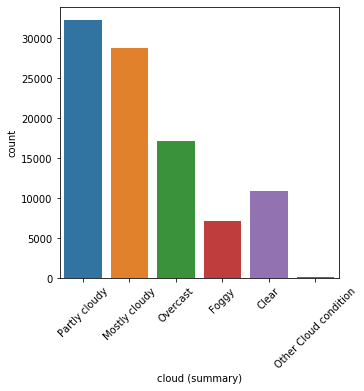

In [28]:
rcParams['figure.figsize'] = 5, 5
sns.countplot(df['cloud (summary)']) 
plt.xticks(rotation = 45)

In [29]:
df = df[df['cloud (summary)'] != 'Other Cloud condition']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96243 entries, 0 to 96452
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96243 non-null  object             
 1   Summary                   96243 non-null  object             
 2   Precip Type               95726 non-null  object             
 3   Temperature (C)           96243 non-null  float64            
 4   Apparent Temperature (C)  96243 non-null  float64            
 5   Humidity                  96243 non-null  float64            
 6   Wind Speed (km/h)         96243 non-null  float64            
 7   Wind Bearing (degrees)    96243 non-null  float64            
 8   Visibility (km)           96243 non-null  float64            
 9   Daily Summary             96243 non-null  object             
 10  Date                      96243 non-null  datetime64[ns, UTC]
 11  year           

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

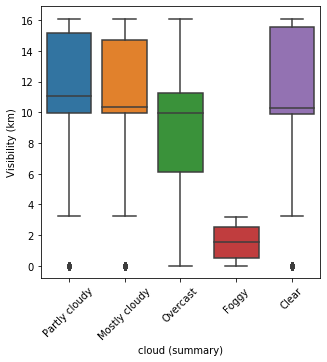

In [51]:
sns.boxplot(x=df['cloud (summary)'], y=df['Visibility (km)']) 
plt.xticks(rotation = 45)

In [16]:
def cloud_categorizer(row):
    row = str(row).lower()
    category = ""
    if "foggy" in row:
        category = 5
    elif "overcast" in row:
        category = 4
    elif "mostly cloudy" in row:
        category = 3
    elif "partly cloudy" in row:
        category = 2
    elif "clear" in row:
        category = 1
    else:
        category = 4 
    return category 

df["cloud (summary)"] = df.apply (lambda row:cloud_categorizer(row["Summary"]) , axis = 1)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

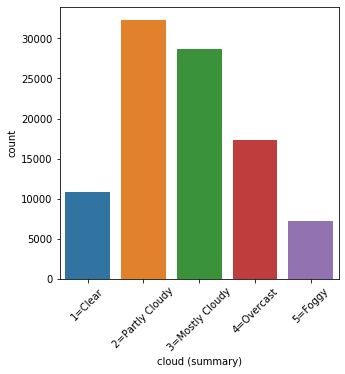

In [17]:
ax=sns.countplot(df['cloud (summary)'])
ax.set_xticklabels(('1=Clear', '2=Partly Cloudy', '3=Mostly Cloudy', '4=Overcast', '5=Foggy'))
plt.xticks(rotation = 45)

In [18]:
df['Daily Summary'].value_counts()

Mostly cloudy throughout the day.                                                       20085
Partly cloudy throughout the day.                                                        9981
Partly cloudy until night.                                                               6169
Partly cloudy starting in the morning.                                                   5184
Foggy in the morning.                                                                    4201
                                                                                        ...  
Overcast starting in the morning.                                                          24
Breezy and foggy starting in the evening.                                                  24
Partly cloudy throughout the day and breezy in the afternoon.                              24
Partly cloudy starting overnight continuing until evening and breezy in the morning.       24
Foggy starting overnight continuing until morning and breezy

[Text(0, 0, '1=Clear'),
 Text(0, 0, '2=Partly Cloudy'),
 Text(0, 0, '3=Mostly Cloudy'),
 Text(0, 0, '4=Overcast'),
 Text(0, 0, '5=Foggy')]

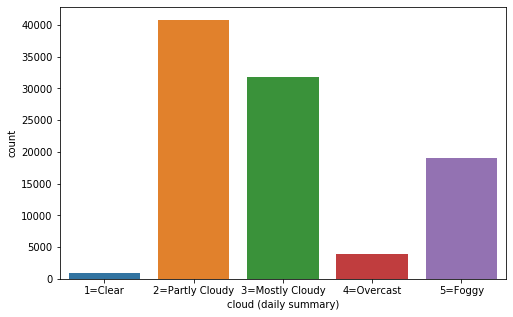

In [19]:
df["cloud (daily summary)"] = df.apply (lambda row:cloud_categorizer(row["Daily Summary"]) , axis = 1)
rcParams['figure.figsize'] = 8, 5
ax=sns.countplot(df['cloud (daily summary)'])
ax.set_xticklabels(('1=Clear', '2=Partly Cloudy', '3=Mostly Cloudy', '4=Overcast', '5=Foggy'))

In [20]:
#Drawing a heatmap
def facet_heatmap(data, color, **kws):
    values=data.columns.values[3]
    data = data.pivot(index='day', columns='hour', values=values)
    sns.heatmap(data, cmap='coolwarm', **kws)  

#Joining heatmaps of every month in a year 
def weather_calendar(year,weather): #Year= Any year in DataFrame. Weather=Any quantitative variable
    dfyear = df[df['year']==year][['month', 'day', 'hour', weather]]
    vmin=dfyear[weather].min()
    vmax=dfyear[weather].max()
    with sns.plotting_context(font_scale=12):
        g = sns.FacetGrid(dfyear,col="month", col_wrap=3) #One heatmap per month
        g = g.map_dataframe(facet_heatmap,vmin=vmin, vmax=vmax)
        g.set_axis_labels('Hour', 'Day')
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle('%s Calendar. Year: %s.' %(weather, year), fontsize=18)

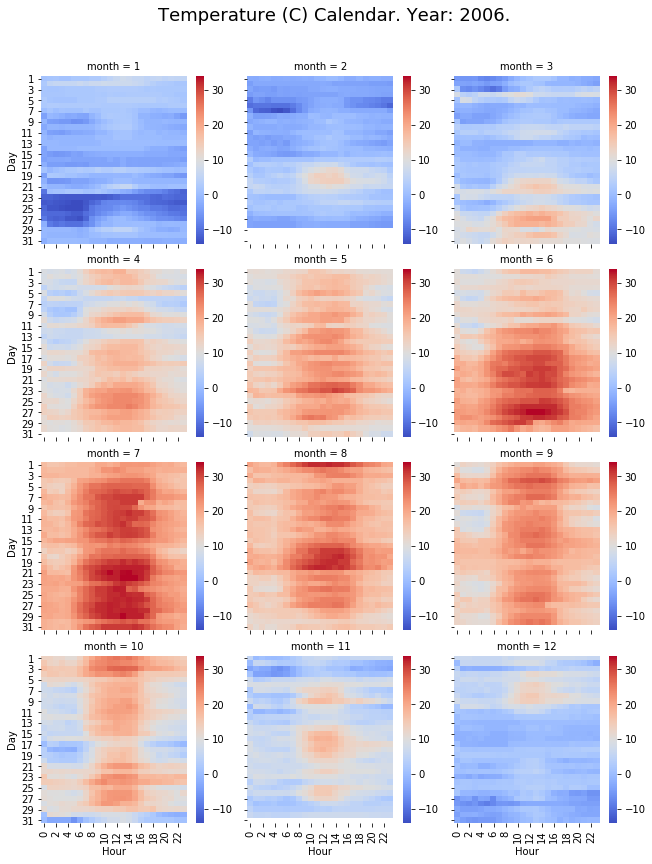

In [21]:
weather_calendar(2006,'Temperature (C)')

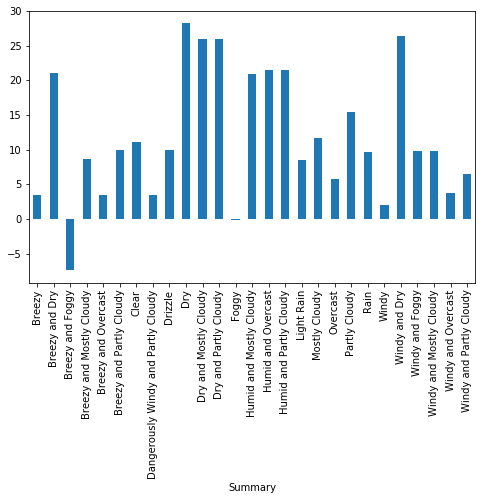

In [22]:
df.groupby('Summary').mean()["Apparent Temperature (C)"].plot(kind='bar')

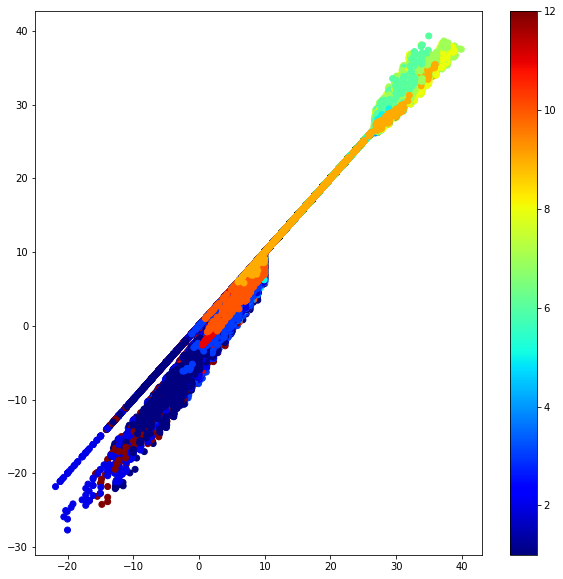

In [53]:
plt.scatter(df['Temperature (C)'], df['Apparent Temperature (C)'], c=df['month'], cmap=plt.cm.jet)
plt.colorbar()


## Start using the linear regression to get predictions

In [33]:
df.dropna()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Daily Summary,Date,year,month,day,hour,cloud (summary)
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,Partly cloudy throughout the day.,2006-03-31 22:00:00+00:00,2006,3,31,22,Partly cloudy
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,Partly cloudy throughout the day.,2006-03-31 23:00:00+00:00,2006,3,31,23,Partly cloudy
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,Partly cloudy throughout the day.,2006-04-01 00:00:00+00:00,2006,4,1,0,Mostly cloudy
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,Partly cloudy throughout the day.,2006-04-01 01:00:00+00:00,2006,4,1,1,Partly cloudy
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,Partly cloudy throughout the day.,2006-04-01 02:00:00+00:00,2006,4,1,2,Mostly cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,Partly cloudy starting in the morning.,2016-09-09 17:00:00+00:00,2016,9,9,17,Partly cloudy
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,Partly cloudy starting in the morning.,2016-09-09 18:00:00+00:00,2016,9,9,18,Partly cloudy
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,Partly cloudy starting in the morning.,2016-09-09 19:00:00+00:00,2016,9,9,19,Partly cloudy
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,Partly cloudy starting in the morning.,2016-09-09 20:00:00+00:00,2016,9,9,20,Partly cloudy


In [34]:
dummies = pd.get_dummies(df["cloud (summary)"])

In [37]:
# df.head(5)
dummies[0:10]

,Clear,Foggy,Mostly cloudy,Overcast,Partly cloudy
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,1,0,0
5,0,0,0,0,1
6,0,0,0,0,1
7,0,0,0,0,1
8,0,0,0,0,1
9,0,0,0,0,1


In [75]:
weather_temp = df[['Temperature (C)', 'Humidity', 'year', 'month', 'hour']]    
weather_data = pd.concat([weather_temp, dummies],axis=1)

KeyError: "None of [Index(['Temperature (C)', 'Humidity', 'year', 'month', 'hour'], dtype='object')] are in the [columns]"

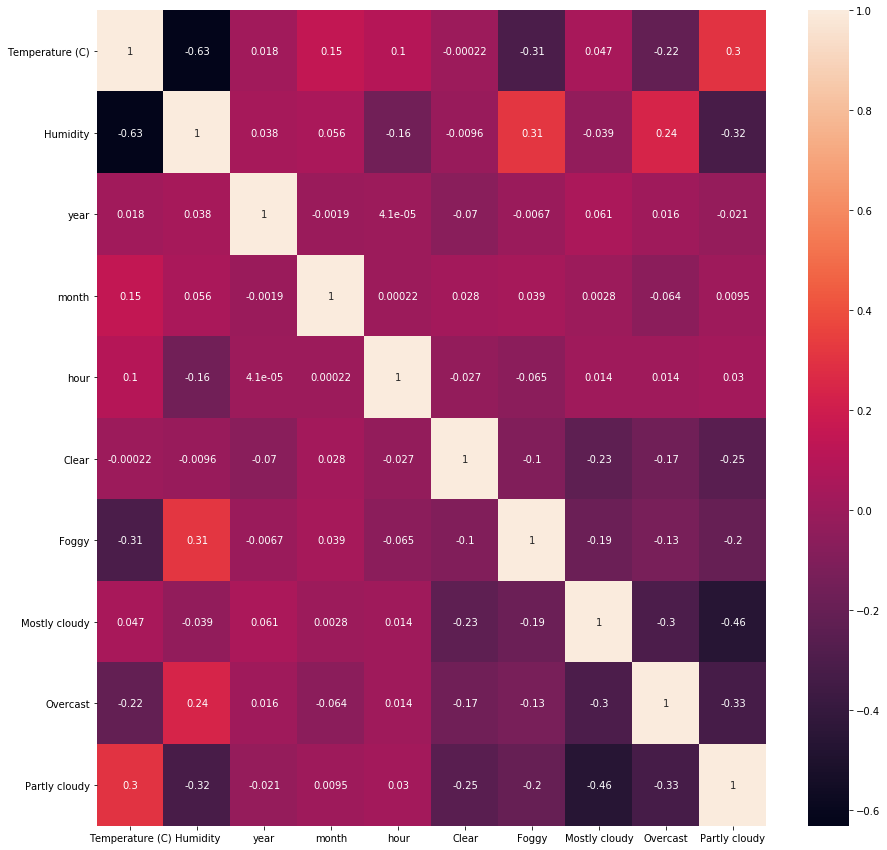

In [39]:
corr = weather_data.corr()
rcParams['figure.figsize'] = 15, 15
sns.heatmap(corr, annot = True)

In [47]:
X = weather_data.drop(['Temperature (C)'], axis=1)
Y = weather_data["Temperature (C)"]


In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)


In [49]:
X_train.shape, y_train.shape

((67370, 9), (67370,))

In [54]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
results = model.fit(X_train, y_train)

In [55]:
r_sq = model.score(X_train, y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.45990678225534365


In [56]:
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: -218.62316632730577
slope: [-2.74321619e+01  1.22619244e-01  4.95160252e-01 -1.02896586e-03
  6.94114177e-01 -3.93898411e+00  1.25387080e+00 -5.36452693e-01
  2.52745182e+00]


In [58]:
y_pred = model.predict(X_test)

In [69]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
2217,-2.405556,3.656371
65695,21.072222,12.526393
79767,33.977778,27.245875
25762,9.955556,5.996123
42441,12.105556,15.561180
...,...,...
86322,10.511111,9.257521
15938,8.461111,6.869998
13818,27.033333,20.885455
28156,3.283333,9.529619


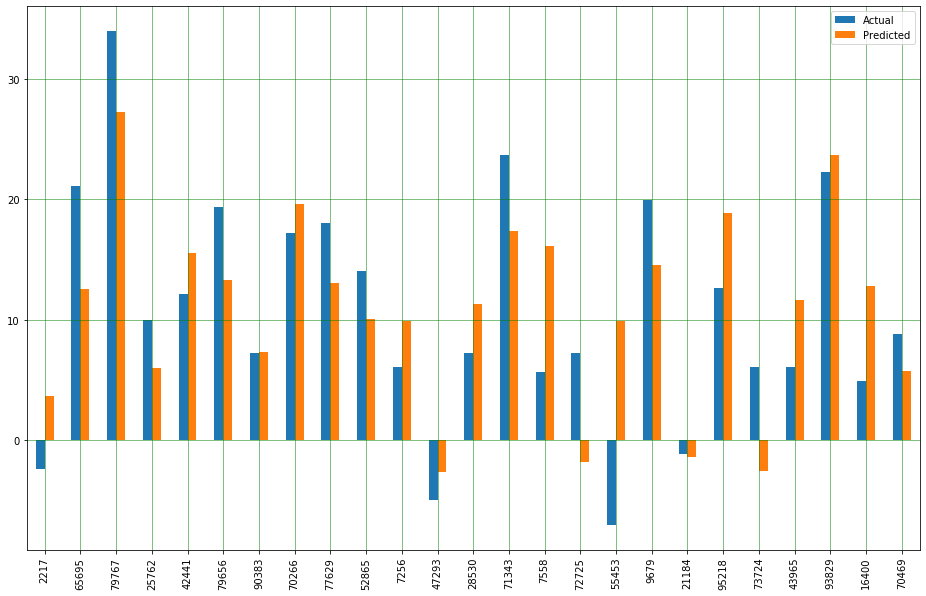

In [73]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [68]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.684257174380152
Mean Squared Error: 48.696642876580995
Root Mean Squared Error: 6.978297992818951


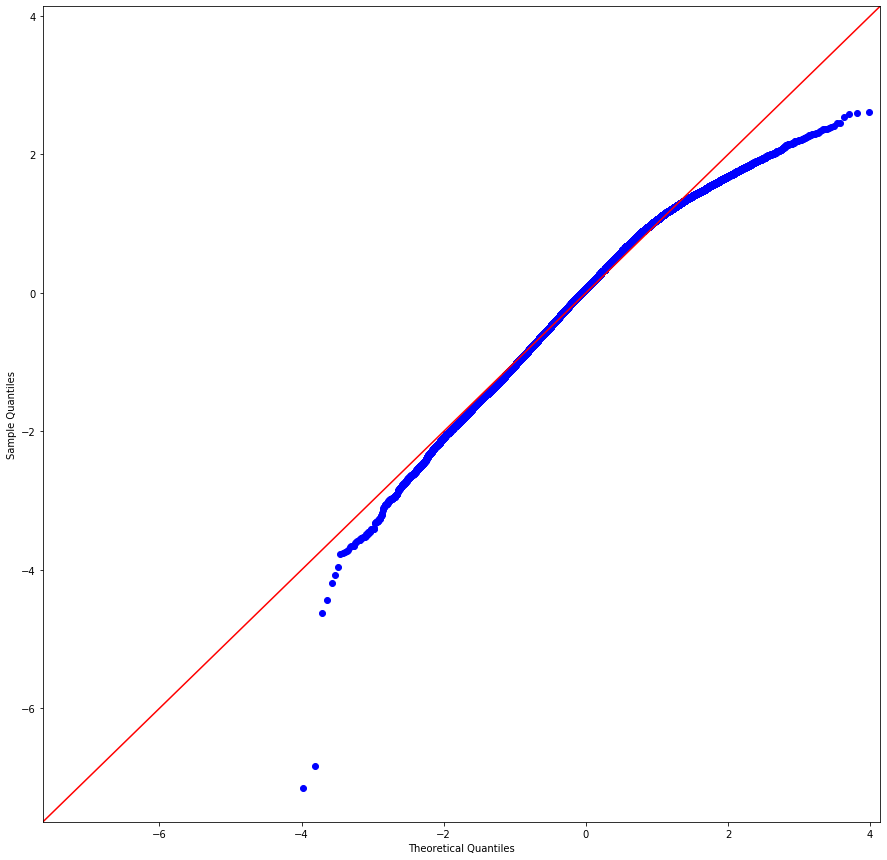

<Figure size 864x576 with 0 Axes>

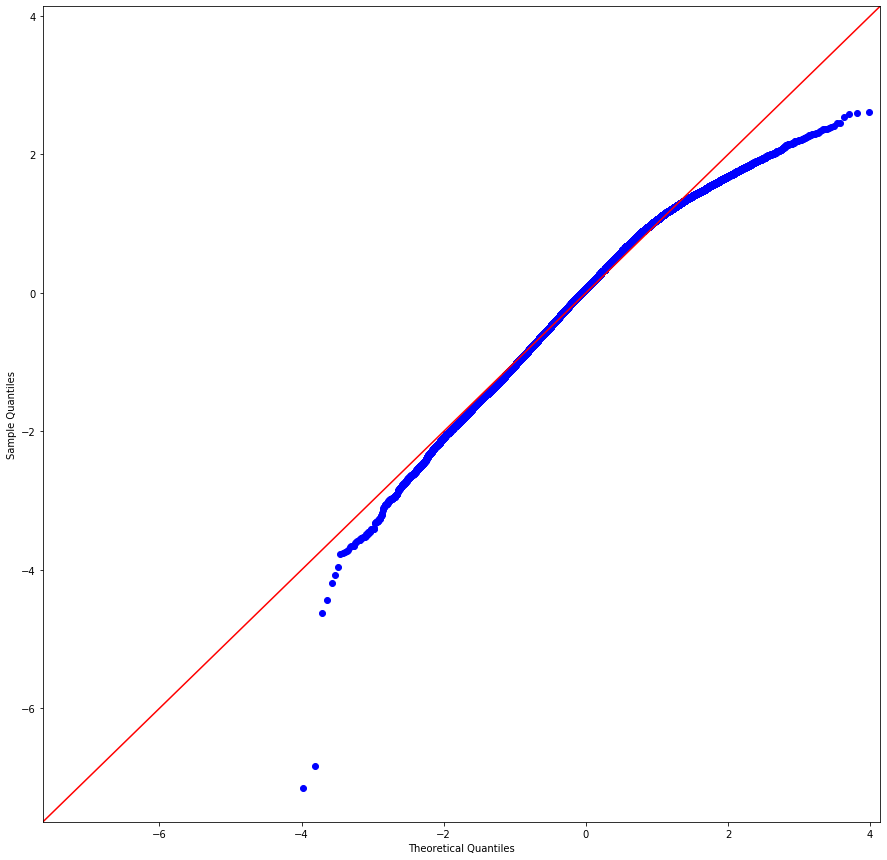

In [77]:
plt.figure(figsize=(12, 8))
residue = y_test - y_pred
qqplot(residue, line = '45', fit='True')

Ideally, this should be a straight line, so the model is doing decent

### Conclusion, this is a general demonstration of how we can use linear regression to predict values. The model does not have the best predictive performance, but that is another topic for another day. 